In [1]:
%reload_ext autoreload
%autoreload 2

In [3]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud

In [4]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [104]:
# Initialize DataLoader
data_loader = SlackDataLoader("../anonymized")
data_loader.channels

[{'id': 'C03T0APHX63',
  'name': 'all-community-building',
  'created': 1660301317,
  'creator': 'U03TEPYRM2P',
  'is_archived': False,
  'is_general': False,
  'members': ['U03T89ACUUW',
   'U03TEPYRM2P',
   'U03TNP8Q8CT',
   'U03TT5KEYCF',
   'U03TX2VN6H5',
   'U03U1FNPEUX',
   'U03U1GHT39V',
   'U03U1HAG9TR',
   'U03U1J51VFZ',
   'U03U4GULU3Y',
   'U03U93GNNVB',
   'U03U9DB7REG',
   'U03U9EJR362',
   'U03UAKATQ22',
   'U03UD4FEDHB',
   'U03UD5B7C3X',
   'U03UD63A8PP',
   'U03UD68RQH3',
   'U03UDBUL7CL',
   'U03UDKKESB1',
   'U03UFV7HFNF',
   'U03UG0SFHGT',
   'U03UG0YHAUT',
   'U03UG1Z21JP',
   'U03UG32J3PC',
   'U03UG4Q7V42',
   'U03UG5VFN03',
   'U03UH397319',
   'U03UHB8CXDY',
   'U03UJGFG2HJ',
   'U03UJGP0C68',
   'U03UJGRN5E0',
   'U03UJH1EQQL',
   'U03UJKJGRAQ',
   'U03UJN29Y4C',
   'U03UKL27B0R',
   'U03UL5LSTG9',
   'U03UP7V9Q57',
   'U03UUMR26Q1',
   'U03UUN8M4RX',
   'U03UUP56MDF',
   'U03UUR571A5',
   'U03UUS0MZCZ',
   'U03UVHCV6KB',
   'U03UYNR4TS4',
   'U03V1AM5TFA',
  

In [90]:
all_week_1_path = os.path.join("../anonymized", 'all-week1/')
week1_df = utils.slack_parser(all_week_1_path)
week1_df.head()

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel
0,message,I use vscode extension for notebook and it wor...,Phillip Atkins,1661324676.252859,text,1661318940.506229,0,0,0,0,
1,message,you have to fetch and merge first (if you are ...,Judith Bolton,1661324702.743019,text,1661324702.743019,1,1,U03UHB8CXDY,1661325717.923899,
2,message,"Try ""git pull"" first",Steven Garcia,1661324717.409309,text,1661324564.397769,0,0,0,0,
3,message,how do I combine handset type and handset manu...,Cheryl Hudson,1661325042.337519,text,1661325042.337519,3,3,"U03UH397319,U03U1J51VFZ,U03UVHCV6KB",1661330120.226419,
4,message,You can select first a subset of the top 3 man...,Brenda Hernandez,1661325357.761809,text,1661325042.337519,0,0,0,0,


In [91]:
week1_df['reply_count'].value_counts()

0     455
2      21
1      19
4      16
3      10
6      10
5      10
10      2
12      2
7       2
18      1
14      1
8       1
9       1
Name: reply_count, dtype: int64

In [92]:
week1_df['msg_content'].values[0]

'I use vscode extension for notebook and it works great. Maybe you should try that?'

In [49]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/abdi/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [70]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def get_bottom_10_user(data, channel='Random'):
    """get user with the lowest number of message sent to any channel"""
    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

   

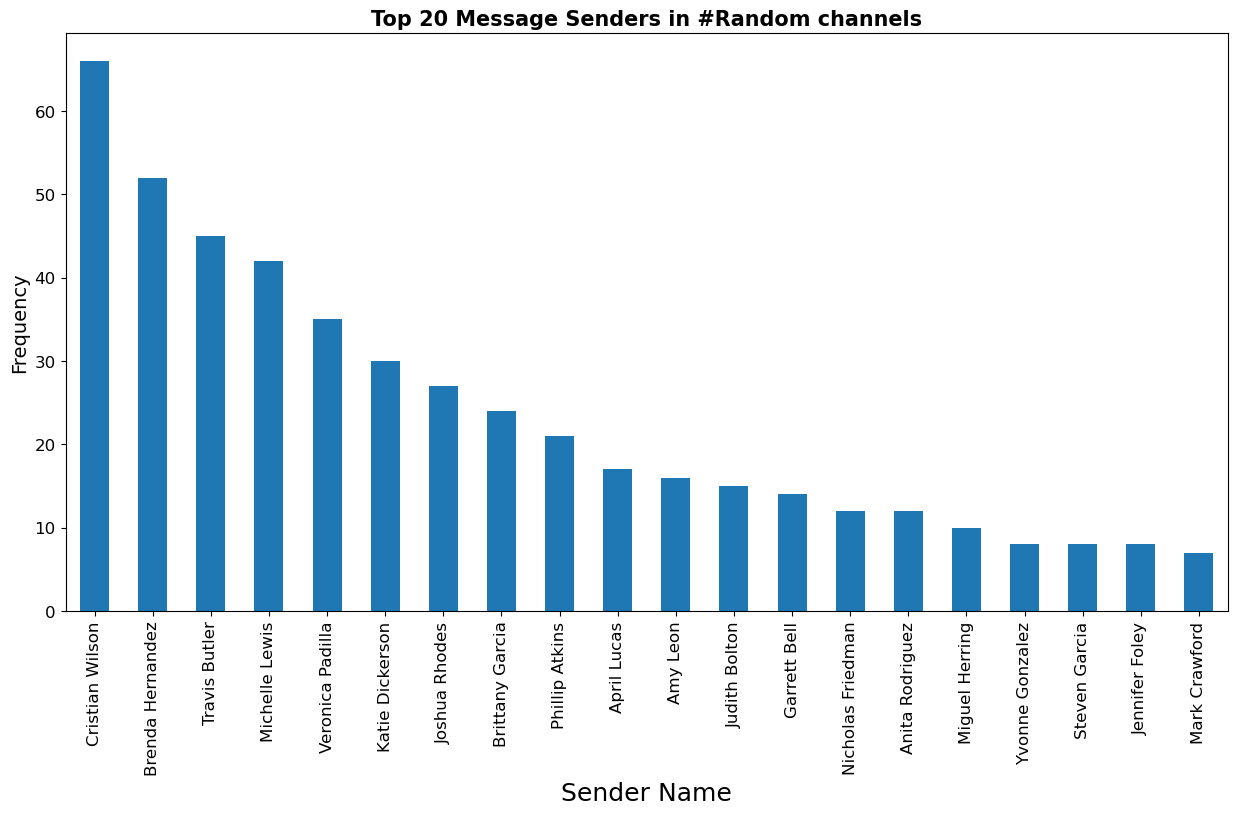

In [41]:
# Get top 20 users with the highest number of messages sent to any channel
get_top_20_user(week1_df)

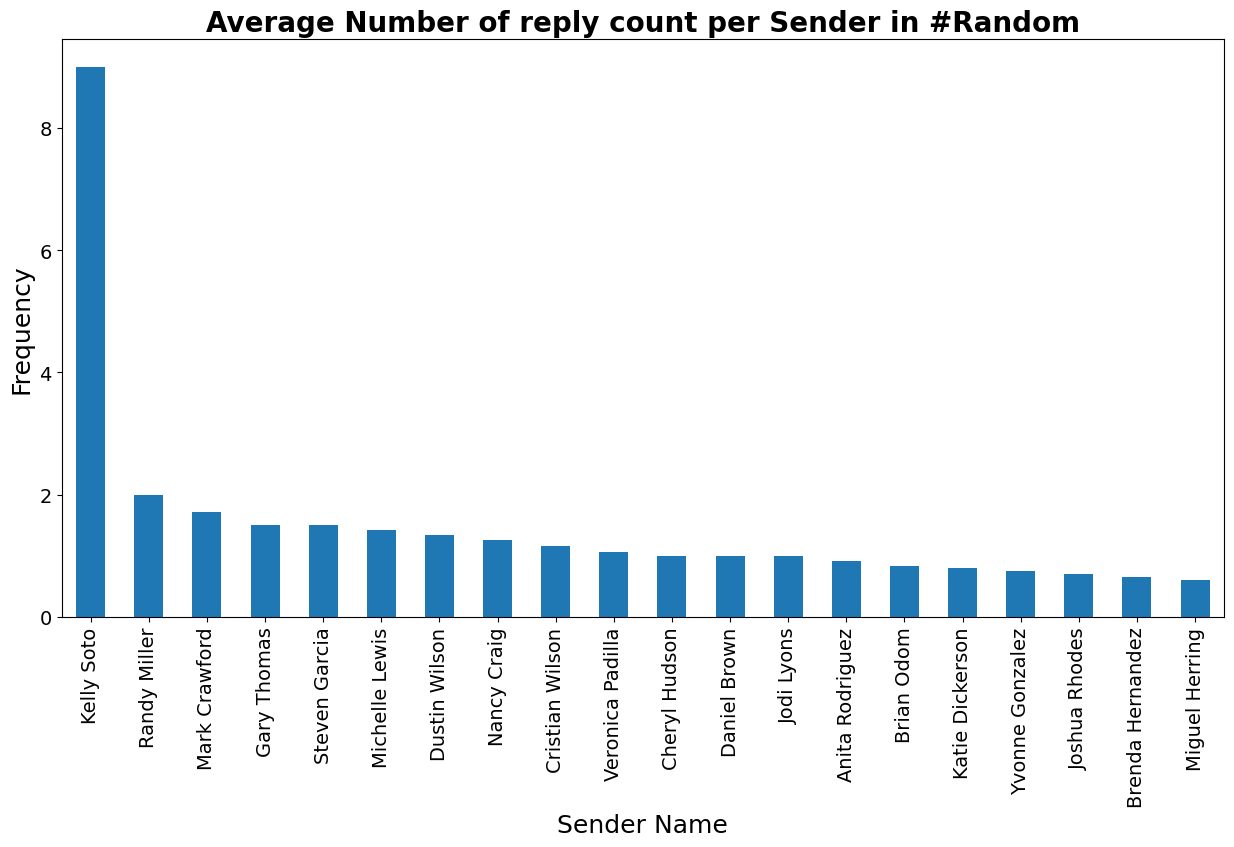

In [42]:
# average number of replies in senders
draw_avg_reply_count(week1_df)

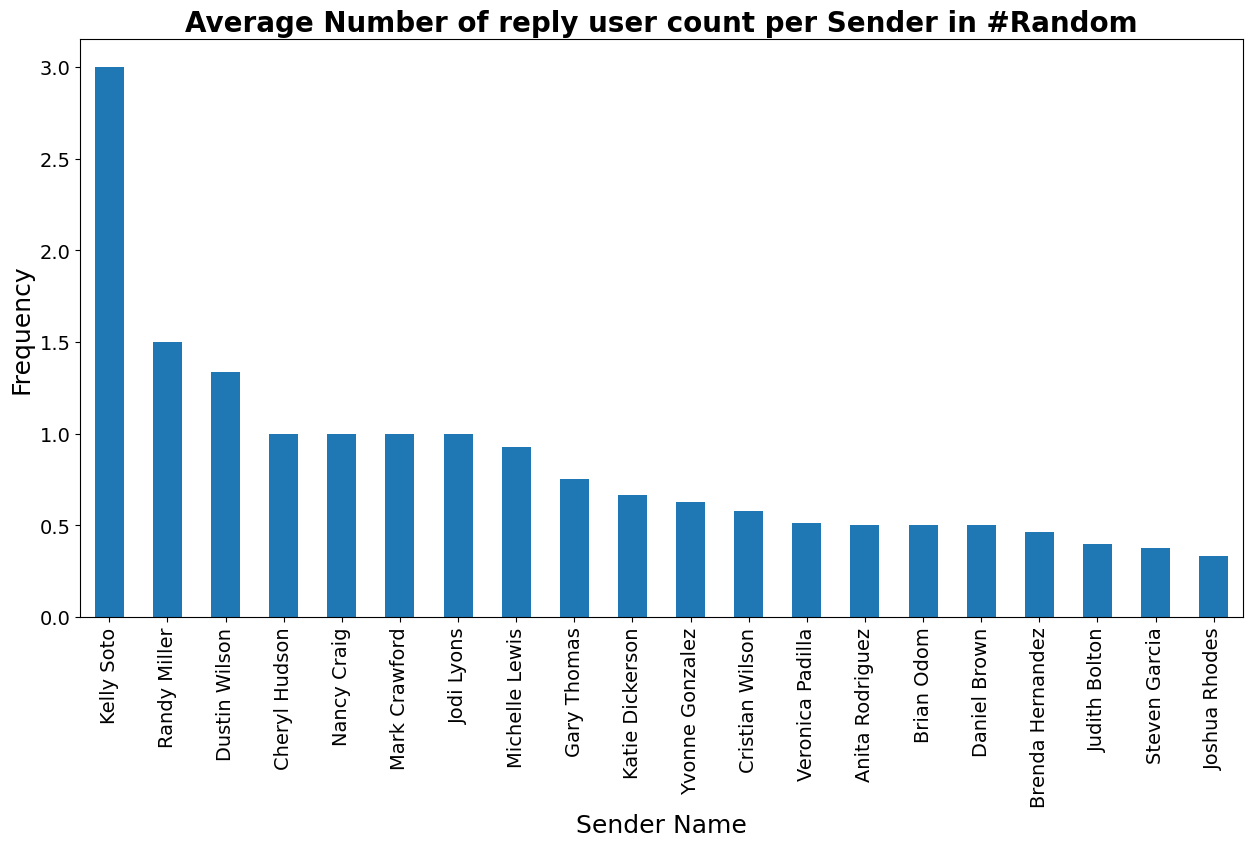

In [46]:
draw_avg_reply_users_count(week1_df)

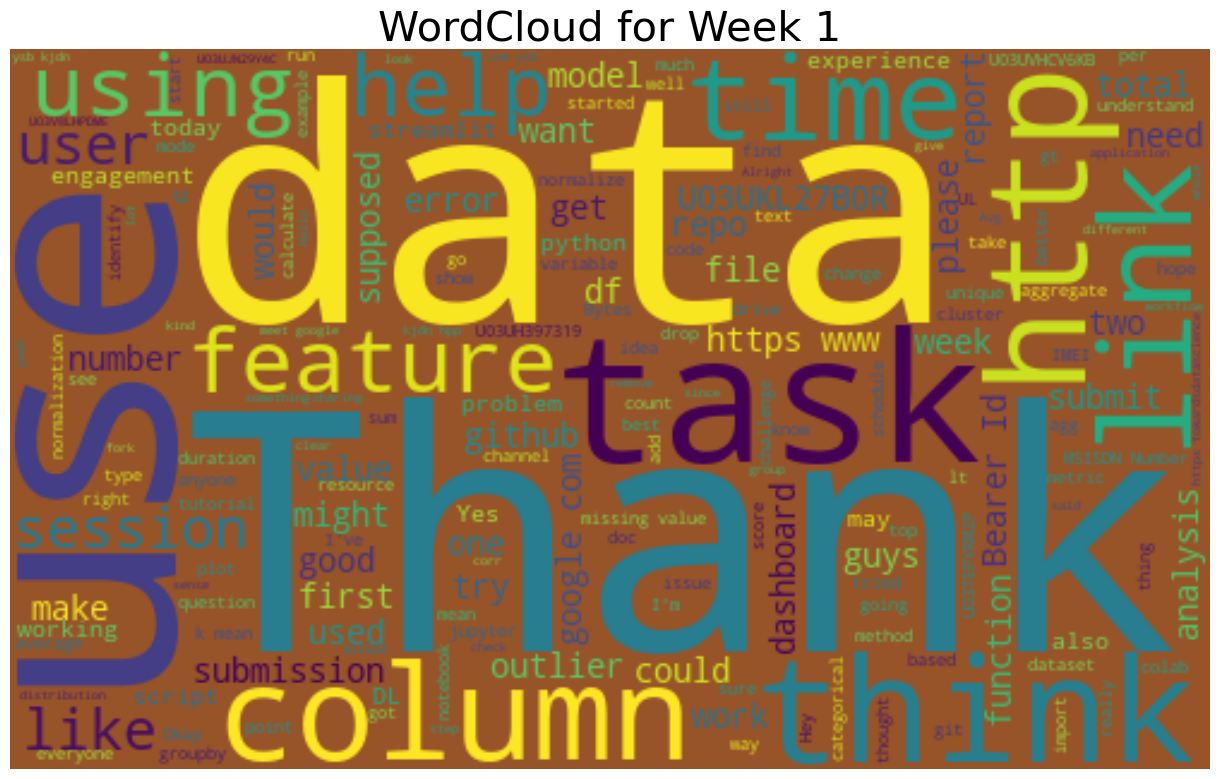

In [50]:
draw_wordcloud(week1_df['msg_content'], 'Week 1')

## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

In [ ]:
# which user has the highest number of reply counts?
Kelly soto

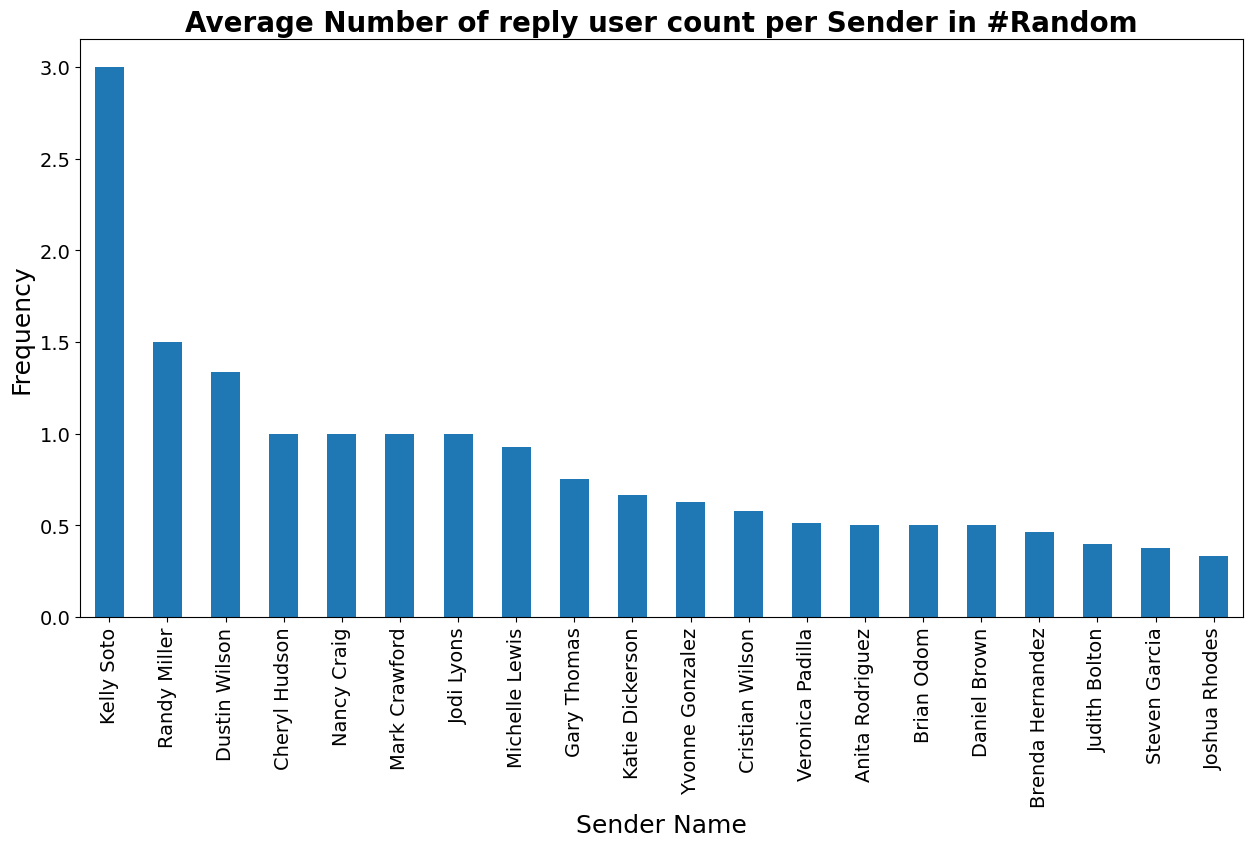

In [53]:
# Visualize reply counts per user per channel
draw_avg_reply_users_count(week1_df)

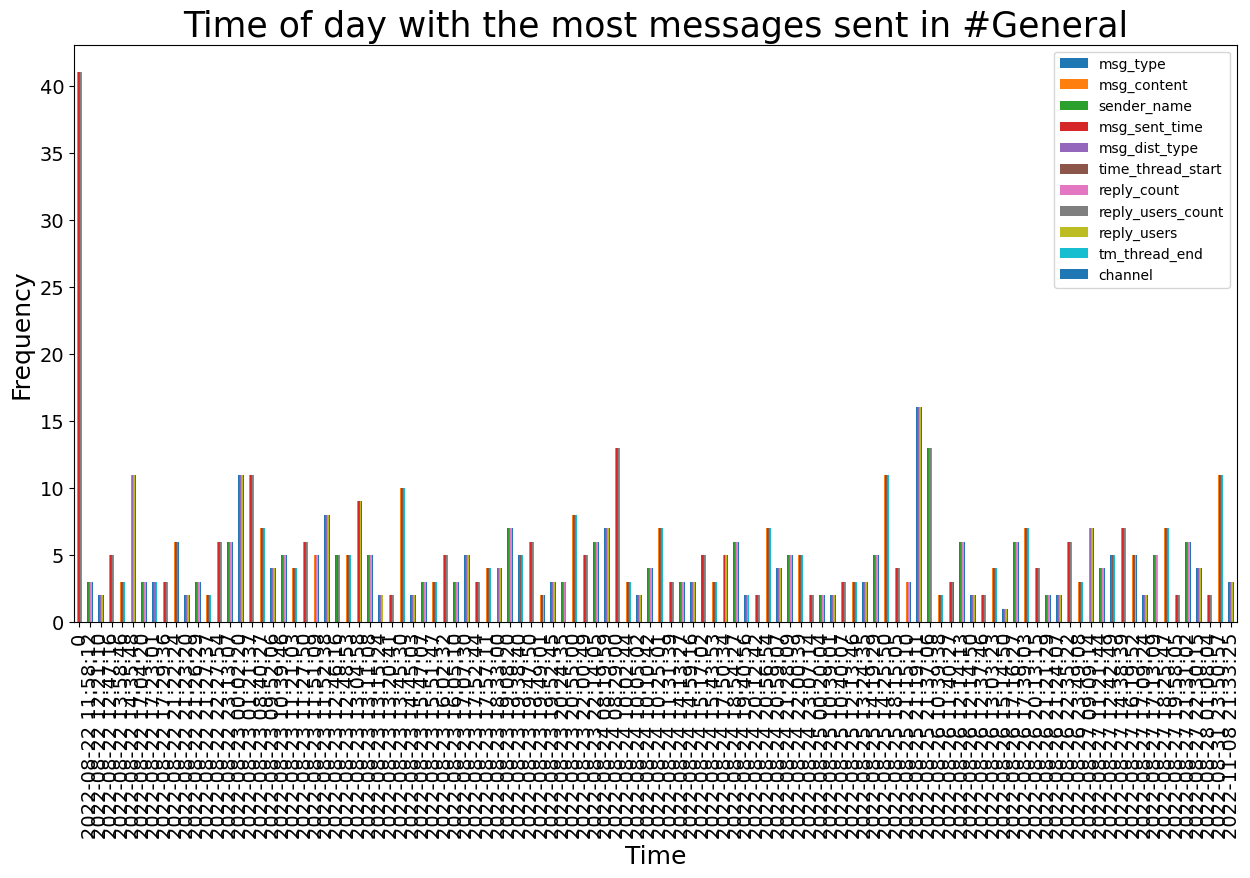

In [77]:
# what is the time range of the day that most messages are sent?
def draw_time_of_day_most_messages_sent(data,channel='General'):
    data.groupby(convert_2_timestamp('time_thread_start', data)).count()\
        .plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'Time of day with the most messages sent in #{channel}', size=25);
    plt.xlabel("Time", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show() 
    
draw_time_of_day_most_messages_sent(week1_df)


In [97]:
week1_df.head()

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel
0,message,I use vscode extension for notebook and it wor...,Phillip Atkins,1661324676.252859,text,1661318940.506229,0,0,0,0,
1,message,you have to fetch and merge first (if you are ...,Judith Bolton,1661324702.743019,text,1661324702.743019,1,1,U03UHB8CXDY,1661325717.923899,
2,message,"Try ""git pull"" first",Steven Garcia,1661324717.409309,text,1661324564.397769,0,0,0,0,
3,message,how do I combine handset type and handset manu...,Cheryl Hudson,1661325042.337519,text,1661325042.337519,3,3,"U03UH397319,U03U1J51VFZ,U03UVHCV6KB",1661330120.226419,
4,message,You can select first a subset of the top 3 man...,Brenda Hernandez,1661325357.761809,text,1661325042.337519,0,0,0,0,


In [81]:
# what kind of messages are replied faster than others?
def messages_replied_faster(data, channel='Random'):
    data.groupby('msg_type')['time_thread_start'].mean().plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Messages replied faster than others in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Msg type", size=18); plt.ylabel("Time", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

messages_replied_faster(week1_df)

TypeError: can only concatenate str (not "int") to str

In [99]:
# Relationship between # of messages and # of reactions
all_week_1_path = os.path.join("../anonymized", 'all-week1/')
week1_reactions_df = utils.parse_slack_reaction(all_week_1_path)
week1_reactions_df.head()

,reaction_name,reaction_count,reaction_users_count,message,user_id,channel
0,+1,2,"U03U1HAG9TR,U03UVHCV6KB",I use vscode extension for notebook and it wor...,U03UG4Q7V42,Random
1,white_check_mark,1,U03UG32J3PC,you have to fetch and merge first (if you are ...,U03UJGP0C68,Random
2,+1,1,U03UJGP0C68,tnx i fixed it,U03UHB8CXDY,Random
3,white_check_mark,1,U03UVHCV6KB,we are asked to calculate correlation for the...,U03UJGRN5E0,Random
4,raised_hands,1,U03UVHCV6KB,we are asked to calculate correlation for the...,U03UJGRN5E0,Random


In [16]:
# Classify messages into different categories such as questions, answers, comments, etc.

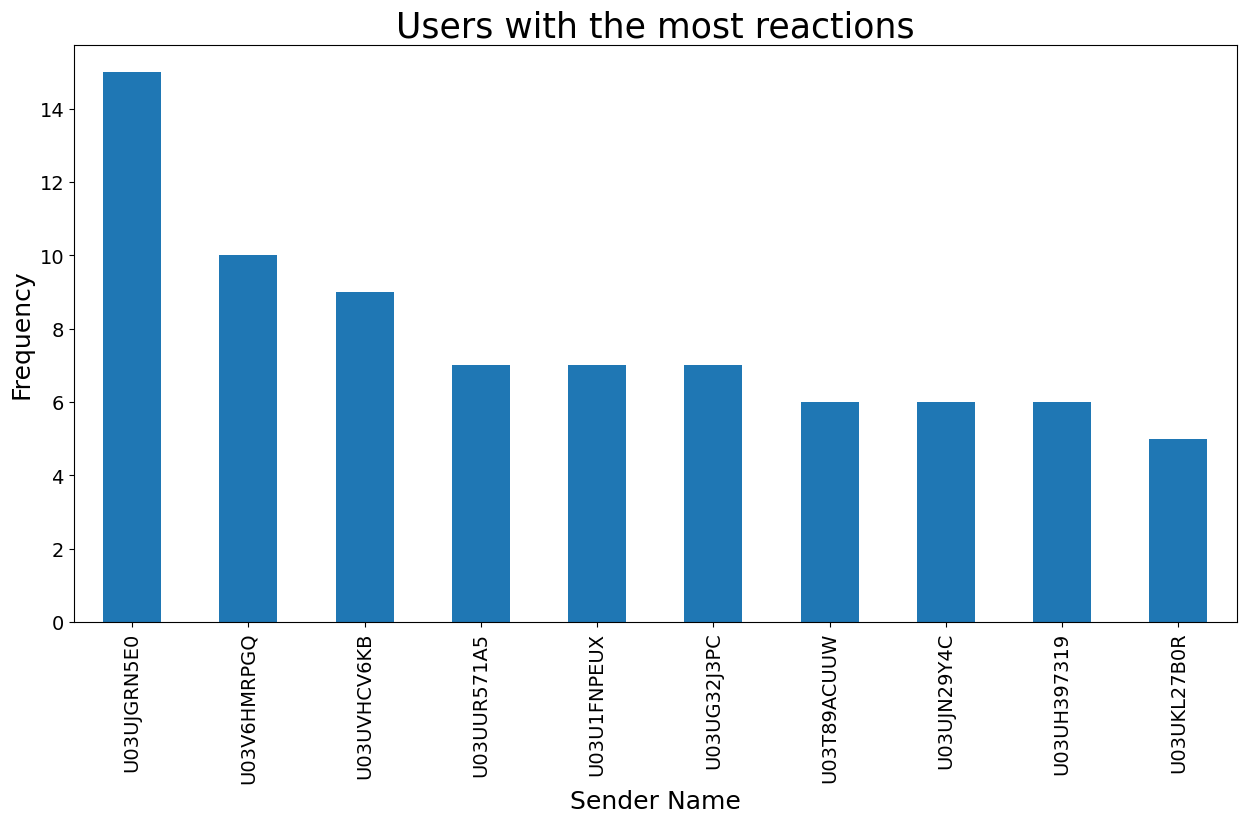

In [100]:
# Which users got the most reactions?
week1_reactions_df.groupby('user_id')['reaction_count'].sum()\
    .sort_values(ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
plt.title(f'Users with the most reactions', size=25);
plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
plt.xticks(size=14); plt.yticks(size=14);
plt.show()

In [106]:
# Model topics mentioned in the channel
channels_list = data_loader.channels
channels_df =  pd.DataFrame(channels_list)
 channels_df['topic']


,id,name,created,creator,is_archived,is_general,members,topic,purpose,pins
0,C03T0APHX63,all-community-building,1660301317,U03TEPYRM2P,False,False,"[U03T89ACUUW, U03TEPYRM2P, U03TNP8Q8CT, U03TT5...","{'value': '', 'creator': '', 'last_set': 0}","{'value': '', 'creator': '', 'last_set': 0}",NaN
1,C03T0AX4K6K,all-technical-support,1660301462,U03TEPYRM2P,False,False,"[U03T89ACUUW, U03TEPYRM2P, U03TNP8Q8CT, U03TT5...","{'value': '', 'creator': '', 'last_set': 0}","{'value': '', 'creator': '', 'last_set': 0}",NaN
2,C03T89KDGA2,all-career-exercises,1660301361,U03TEPYRM2P,False,False,"[U03T89ACUUW, U03TEPYRM2P, U03TNP8Q8CT, U03TT5...","{'value': '', 'creator': '', 'last_set': 0}","{'value': '', 'creator': '', 'last_set': 0}","[{'id': '1663839365.770289', 'type': 'C', 'cre..."
3,C03T89PMJKG,all-resources,1660301441,U03TEPYRM2P,False,False,"[U03T89ACUUW, U03TEPYRM2P, U03TNP8Q8CT, U03TT5...","{'value': '', 'creator': '', 'last_set': 0}","{'value': '', 'creator': '', 'last_set': 0}","[{'id': '1667584331.857749', 'type': 'C', 'cre..."
4,C03TBUCU4UD,random,1660300985,U03TEPYRM2P,False,False,"[U03T89ACUUW, U03TEPYRM2P, U03TNP8Q8CT, U03TT5...","{'value': '', 'creator': '', 'last_set': 0}","{'value': 'This channel is for... well, everyt...",NaN


In [ ]:
# What are the topics that got the most reactions?

### Harder questions to look into

In [ ]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?